# Part 2: Spatial Interaction Models

### Read in OD data (“symbolic” population and the number of jobs for the stations)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from operator import itemgetter

In [2]:
#read in the London flows data
flows = pd.read_csv("london_flows.csv")

In [3]:
#import the necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import scipy.stats
import numpy as np
from math import sqrt
import statsmodels.formula.api as smf

## 删除距离为0的行

In [4]:
flows.drop(flows[flows['distance']==0].index,axis=0,inplace=True)

In [5]:
flows[flows['distance']==0]

,station_origin,station_destination,flows,population,jobs,distance


## 编辑人口和工作为0的行

In [6]:
#set the number to a very small number
flows['jobs']=flows.apply(lambda x:0.00000001 if x['jobs'] == 0 else x['jobs'], axis=1)
flows['population']=flows.apply(lambda x:0.00000001 if x['population'] == 0 else x['population'], axis=1)

In [7]:
# produce logarithms of them
x_variables = ["population", "jobs","distance"]
log_x_vars = []
for x in x_variables:
    flows[f"log_{x}"] = np.log(flows[x])
    log_x_vars.append(f"log_{x}")
flows.head(5)

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274


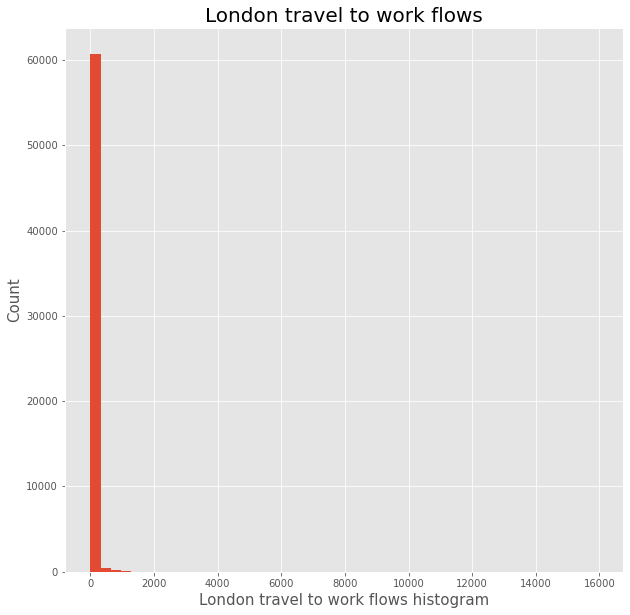

In [18]:
plt.style.use('ggplot')
plt.subplots(figsize=(10,10))

plt.hist(flows["flows"], histtype="stepfilled" , bins = 50)
plt.xlabel("London travel to work flows histogram", fontsize = 15)
plt.ylabel("Count", fontsize= 15)
plt.title("London travel to work flows", fontsize = 20)
plt.grid(True)

## 2.1 Choose Model and Calibrate The Parameter Beta

### Testing the "Goodness-of-fit" for 4 Models

Goodness-of-fit is the correct term for checking how well your model estimates match up with your observed flows: the two most common are to look at the coefficient of determination ($r^2$) or the Square Root of Mean Squared Error (RMSE). import statsmodels.api as sm
import statsmodels.formula.api as smf$r^2$ is popular as it is quite intuitive and can be compared across models. RMSE is less intuitive, but some argue that it is better for comparing changes to the same model. Here we’ll do both…

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [9]:
#set up the metric calculations
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE


In [10]:
# Create list of models - unconstrained, production constrained, attraction constrained and doubly constrained
models = ['uncon', 'prodcon', 'attrcon', 'doubcon']

# Create list of distance decay function
decay_funs = ['pow', 'exp']

# Create DoD of formulae for all models
formulae = {'uncon': {'pow': 'flows ~ log_population + log_jobs + log_distance', 
                      'exp': 'flows ~ log_population + log_jobs + distance'}, 
            'prodcon': {'pow': 'flows ~ station_origin + log_jobs + log_distance -1',
                        'exp': 'flows ~ station_origin + log_jobs + distance -1'}, 
            'attrcon': {'pow': 'flows ~ station_destination + log_population + log_distance -1', 
                        'exp': 'flows ~ station_destination + log_population + distance -1'},
            'doubcon': {'pow': 'flows ~ station_origin + station_destination + log_distance -1', 
                        'exp': 'flows ~ station_origin + station_destination + distance -1'}}

# Create dictionary to retrieve valuue of beta, depending on which distance decay function was used
beta_dict = {'pow': 'log_distance', 
             'exp': 'distance'}

# Create dictionaries to print models and function
models_dict = {'uncon': 'unconstrained', 
               'prodcon': 'production-constrained', 
               'attrcon': 'attraction-constrained', 
               'doubcon': 'doubly-constrained'}
funs_dict = {'pow': 'negative power', 
             'exp': 'negative exponential'}

In [11]:
# For each model
for model in models:
    # For each distance decay function
    for decay_fun in decay_funs:
        
        ## ----- ADMIN AND MODEL FITTING ----- ##
        
        # Print model and distance decay function used
        print(f'Fitting {models_dict[model]} model with {funs_dict[decay_fun]} distance decay function:')
        
        # Fit model
        formula = formulae[model][decay_fun]
        reg_model = smf.glm(formula = formula, 
                            data=flows, 
                            family=sm.families.Poisson()).fit()
        
        ## ----- PREDICTED VALUE ----- ##
        
        # Get predicted value back in dataframe
        predictions = reg_model.get_prediction()
        predictions_summary_frame = predictions.summary_frame()
        flows[f"{model}_{decay_fun}_fitted"] = predictions_summary_frame["mean"]
        
        ## ----- VALUES OF PARAMETER ----- ##
        
        # Get values of parameters
        coefs = pd.DataFrame(reg_model.params)
        coefs.reset_index(inplace=True)
        coefs.rename(columns = {0:"value", "index":"parameter"}, inplace = True)
        
        # If model is unconstrained
        if model == 'uncon':
            # Value of k
            flows[f"{model}_{decay_fun}_k"] = np.exp(coefs[coefs.parameter == 'Intercept'].value.item())
            # Value of alpha
            flows[f"{model}_{decay_fun}_alpha"] = coefs[coefs.parameter == 'log_population'].value.item()
            # Value of gamma
            flows[f"{model}_{decay_fun}_gamma"] = coefs[coefs.parameter == 'log_jobs'].value.item()
            # Value of beta
            flows[f"{model}_{decay_fun}_beta"] = -coefs[coefs.parameter == beta_dict[decay_fun]].value.item()
        
        # If model is production-constrained or attraction-constrained
        elif model == 'prodcon' or model == 'attrcon':
            # Strings to use for respective models
            if model == 'prodcon':
                merge_str = 'station_origin'
                con_str = 'alpha_i'
                other_str = 'gamma'
                other_label = 'log_jobs'  # the other label in coefs df
            else:
                merge_str = 'station_destination'
                con_str = 'gamma_j'
                other_str = 'alpha'
                other_label = 'log_population'  # the other label in coefs df
            # Value of alpha_i (production-constrained) or gamma_j (attraction-constrained)
            to_repl = ["("+merge_str+")", "\[", "\]"]
            for x in to_repl:
                coefs["parameter"] = coefs["parameter"].str.replace(x, "")
            flows = flows.merge(coefs, left_on=merge_str, right_on="parameter", how = "left")
            flows.drop(columns = ["parameter"], inplace = True)
            flows.rename(columns = {"value":f"{model}_{decay_fun}_{con_str}"}, inplace = True)
            # Value of gamma (production-constrained) or alpha (attraction-constrained)
            flows[f"{model}_{decay_fun}_{other_str}"] = coefs[coefs.parameter == other_label].value.item()
            # Value of beta
            flows[f"{model}_{decay_fun}_beta"] = -coefs[coefs.parameter == beta_dict[decay_fun]].value.item()
            
        # If model is doubly-constrained
        elif model == 'doubcon':
            # Value of alpha_i (origin) and gamma_j (destination)
            for con_str in ['alpha_i', 'gamma_j']:
                if con_str == 'alpha_i':
                    merge_str = 'station_origin'
                    other_str = 'gamma_j'
                else:
                    merge_str = 'station_destination'
                    other_str = 'alpha_i'
                coefs_sub = coefs[coefs.parameter.str.contains(merge_str)]
                if merge_str == 'station_origin':
                    to_repl = [merge_str, "\[", "\]"]
                else:
                    to_repl = [merge_str, "\[", "\]"]
                for x in to_repl:
                    coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")
                flows = flows.merge(coefs_sub, left_on=merge_str, right_on="parameter", how = "left")
                flows.drop(columns = ["parameter"], inplace = True)
                flows.rename(columns = {"value":f"{model}_{decay_fun}_{con_str}"}, inplace = True)
            # Value of beta
            flows[f"{model}_{decay_fun}_beta"] = -coefs[coefs.parameter == beta_dict[decay_fun]].value.item()

        ## ----- PERFORMANCE METRICS ----- ##
        
        # Compute R2 and RSME
        print(f'R2 value is {CalcRSqaured(flows["flows"],flows[f"{model}_{decay_fun}_fitted"])}.')
        print(f'RSME value is {CalcRMSE(flows["flows"],flows[f"{model}_{decay_fun}_fitted"])}.')
        print('')


Fitting unconstrained model with negative power distance decay function:
R2 value is 0.32119624673428415.
RSME value is 108.297.

Fitting unconstrained model with negative exponential distance decay function:
R2 value is 0.3622791902075583.
RSME value is 105.685.

Fitting production-constrained model with negative power distance decay function:


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/tmp/ipykernel_71/492306158.py:58: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["parameter"] = coefs["parameter"].str.replace(x, "")


R2 value is 0.3882840746804262.
RSME value is 102.857.

Fitting production-constrained model with negative exponential distance decay function:
R2 value is 0.46807908451203534.
RSME value is 96.23.

Fitting attraction-constrained model with negative power distance decay function:
R2 value is 0.3499586857023694.
RSME value is 105.975.

Fitting attraction-constrained model with negative exponential distance decay function:
R2 value is 0.39997464311276665.
RSME value is 102.132.

Fitting doubly-constrained model with negative power distance decay function:


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/tmp/ipykernel_71/492306158.py:83: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs_sub["parameter"] = coefs_sub["parameter"].str.replace(x, "")


R2 value is 0.40771212061348105.
RSME value is 101.298.

Fitting doubly-constrained model with negative exponential distance decay function:
R2 value is 0.497902774735663.
RSME value is 93.364.



# 求beat

In [13]:
formula_p3 = 'flows ~ station_origin + station_destination + distance -1'
prodsim3 = smf.glm(formula = formula_p3, data=flows, family=sm.families.Poisson()).fit()
#negative exponential
predictionsp3 =prodsim3.get_prediction(flows[["station_origin", "station_destination","distance"]])
predictions_summary_framep3 = predictionsp3.summary_frame()
flows["prodsimest3"] = round(predictions_summary_framep3["mean"],0)

In [14]:
# I would use the double-constrained model, let's check it
print(prodsim3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    60658
Model Family:                 Poisson   Df Model:                          797
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Sun, 01 May 2022   Deviance:                   1.5299e+06
Time:                        13:55:00   Pearson chi2:                 2.02e+06
No. Iterations:                    27                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [15]:
beta_double = -prodsim3.params[-1]

In [16]:
beta_double

0.0001543696921557843

# 从结果可以看出 ， 要选择negative exponential production production-constrained 因为其的模型的解释和残差都更好

In [25]:
formula_p1 = 'flows ~ station_origin + log_jobs + distance -1'
prodsim1 = smf.glm(formula = formula_p1, data=flows, family=sm.families.Poisson()).fit()

In [26]:
#negative exponential
predictionsp1 =prodsim1.get_prediction(flows[["station_origin", "log_jobs","distance"]])
predictions_summary_framep1 = predictionsp1.summary_frame()
flows["prodsimest1"] = round(predictions_summary_framep1["mean"],0)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [27]:
# I would use the production-constrained model, let's check it
print(prodsim1.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61055
Model Family:                 Poisson   Df Model:                          400
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Mon, 02 May 2022   Deviance:                   1.6477e+06
Time:                        00:32:07   Pearson chi2:                 2.40e+06
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [28]:
# Extracting parameters
coefs = pd.DataFrame(prodsim1.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
flows = flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows.drop(columns = ["coef"], inplace = True)

/tmp/ipykernel_71/3457737766.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


In [29]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61456 entries, 0 to 61455
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61456 non-null  object 
 1   station_destination  61456 non-null  object 
 2   flows                61456 non-null  int64  
 3   population           61456 non-null  float64
 4   jobs                 61456 non-null  float64
 5   distance             61456 non-null  float64
 6   log_population       61456 non-null  float64
 7   log_jobs             61456 non-null  float64
 8   log_distance         61456 non-null  float64
 9   jobs_1               61456 non-null  float64
 10  O_i                  61456 non-null  int64  
 11  D_j                  61456 non-null  int64  
 12  prodsimest1          61456 non-null  float64
 13  alpha                61456 non-null  float64
dtypes: float64(9), int64(3), object(2)
memory usage: 7.0+ MB


In [33]:
alpha = prodsim1.params[0:-2]
gamma = prodsim1.params[-2]
beta = -prodsim1.params[-1]
print(beta)

0.0001531661934628474


In [34]:
gamma

0.7552215895876639

In [60]:
formula_p2 = 'flows ~ station_origin + log_jobs + log_distance -1'
prodsim2 = smf.glm(formula = formula_p2, data=flows, family=sm.families.Poisson()).fit()

In [61]:
#negative exponential
predictionsp2 =prodsim2.get_prediction(flows[["station_origin", "log_jobs","log_distance"]])
predictions_summary_framep2 = predictionsp2.summary_frame()
flows["prodsimest2"] = round(predictions_summary_framep2["mean"],0)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


In [63]:
# I would use the production-constrained model, let's check it
print(prodsim2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61456
Model:                            GLM   Df Residuals:                    61055
Model Family:                 Poisson   Df Model:                          400
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Wed, 27 Apr 2022   Deviance:                   1.8615e+06
Time:                        00:03:14   Pearson chi2:                 2.78e+06
No. Iterations:                    26                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

# Scenarios

Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit. Using the 
calibrated parameter beta, compute the new flows for scenario A. Make sure the number of 
commuters is conserved.


In [35]:
#read in the London flows data
flows = pd.read_csv("london_flows.csv")

In [36]:
flows.columns

Index(['station_origin', 'station_destination', 'flows', 'population', 'jobs',
       'distance'],
      dtype='object')

In [37]:
flows.drop(flows[flows['distance']==0].index,axis=0,inplace=True)
#set the number to a very small number
flows['jobs']=flows.apply(lambda x:0.00000001 if x['jobs'] == 0 else x['jobs'], axis=1)
flows['population']=flows.apply(lambda x:0.00000001 if x['population'] == 0 else x['population'], axis=1)
# produce logarithms of them
x_variables = ["population", "jobs","distance"]
log_x_vars = []
for x in x_variables:
    flows[f"log_{x}"] = np.log(flows[x])
    log_x_vars.append(f"log_{x}")

In [38]:
#testing scenario A
def new_sal(row):
    if row["station_destination"] == "Canary Wharf":
        val =row["jobs"]*0.5
    else:
        val = row["jobs"]
    return val
        
flows["jobs_1"] = flows.apply(new_sal, axis =1)

In [39]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(flows.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
flows = flows.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(flows.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
flows = flows.merge(D_j, on = "station_destination", how = "left" )

In [40]:
flow_mat = pd.pivot_table(flows, values ="flows", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flow_mat

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [41]:
formula_p1 = 'flows ~ station_origin + log_jobs + distance -1'
prodsim1 = smf.glm(formula = formula_p1, data=flows, family=sm.families.Poisson()).fit()
#negative exponential
predictionsp1 =prodsim1.get_prediction(flows[["station_origin", "log_jobs","distance"]])
predictions_summary_framep1 = predictionsp1.summary_frame()
flows["prodsimest1"] = round(predictions_summary_framep1["mean"],0)
# Extracting parameters
coefs = pd.DataFrame(prodsim1.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
flows = flows.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
flows.drop(columns = ["coef"], inplace = True)
alpha = prodsim1.params[0:-2]
gamma = prodsim1.params[-2]
beta = -prodsim1.params[-1]
print(beta)

0.0001531661934628474


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/tmp/ipykernel_71/3129308152.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


In [42]:
flows_mat1= flows.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flows_mat1

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [43]:
flows["prodsimest2"] = np.exp(flows["alpha"]+gamma*np.log(flows["jobs_1"]) - beta*flows["distance"])

In [44]:
#first round the estimates
flows["prodsimest2"] = round(flows["prodsimest2"],0)
flows_mat2= flows.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flows_mat2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,555.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3730.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2854.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4765.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3083.0


In [45]:
#calculate some new alpha and beta values
Dj_gamma = flows["jobs_1"]**gamma
dist_beta = flows["distance"]**-beta
#calcualte the first stage of the Ai values
flows["Ai1"] = Dj_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(flows.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i["Ai1"] = A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
flows = flows.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [46]:
#to check everything works, recreate the original estimates
flows["prodsimestsa1"] = flows["A_i"]*flows["O_i"]*Dj_gamma*dist_beta
#round
flows["prodsimestsa1"] = round(flows["prodsimestsa1"])
#check
flows[["prodsimest1","prodsimest2", "prodsimestsa1"]]

,prodsimest1,prodsimest2,prodsimestsa1
0,78.0,78.0,148.0
1,1.0,1.0,3.0
2,4.0,4.0,4.0
3,99.0,59.0,70.0
4,56.0,56.0,43.0
...,...,...,...
61451,99.0,99.0,172.0
61452,295.0,295.0,250.0
61453,36.0,36.0,35.0
61454,125.0,125.0,64.0


In [47]:
flows.head()

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,jobs_1,O_i,D_j,prodsimest1,alpha,prodsimest2,Ai1,A_i,prodsimestsa1
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504,78549.0,599,78549,78.0,-2.914322,78.0,4969.549315,0.00005,148.0
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012,442.0,599,442,1.0,-2.914322,1.0,99.375214,0.00005,3.0
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275,665.0,599,665,4.0,-2.914322,4.0,135.303172,0.00005,4.0
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348,29386.0,599,58772,99.0,-2.914322,59.0,2365.203174,0.00005,70.0
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274,15428.0,599,15428,56.0,-2.914322,56.0,1454.082480,0.00005,43.0


In [19]:
#first round the estimates
flows["prodsimestsa1"] = round(flows["prodsimestsa1"],0)
flows_mat_2= flows.pivot_table(values ="prodsimestsa1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flows_mat_2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,1222.0
Acton Town,NaN,NaN,NaN,24.0,24.0,NaN,4.0,2.0,NaN,25.0,...,21.0,3.0,9.0,7.0,NaN,4.0,NaN,4.0,NaN,3745.0
Aldgate,NaN,NaN,7.0,NaN,19.0,NaN,NaN,1.0,NaN,19.0,...,16.0,NaN,7.0,5.0,NaN,3.0,NaN,3.0,NaN,2891.0
Aldgate East,NaN,NaN,8.0,20.0,NaN,NaN,3.0,2.0,NaN,20.0,...,17.0,3.0,7.0,6.0,NaN,3.0,NaN,3.0,NaN,3179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,12.0,32.0,32.0,NaN,NaN,NaN,NaN,33.0,...,27.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,4870.0
Woodgrange Park,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,531.0
Woodside Park,NaN,NaN,8.0,21.0,21.0,NaN,4.0,NaN,NaN,22.0,...,18.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,3090.0


#### Visualize the flow change in Scenario A

In [50]:
#count the change
diff_1 = flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest2':'sum','prodsimestsa1':'sum'})
diff_1["differences"]= diff_1["flows"] - diff_1["prodsimestsa1"]

diff_1["diff_abs"]= abs(diff_1["differences"])
#diff_1.sort_values(by=["differences"],ascending= False, inplace = True)
diff_1['change'] = (diff_1['flows']/1542283.0)-(diff_1['prodsimestsa1']/1542283.0)
diff_1.sort_values(by=["differences"],ascending= False, inplace = True)
diff_1.head(21)

,station_destination,flows,prodsimest2,prodsimestsa1,differences,diff_abs,change
55,Canary Wharf,58772,28243.0,30481.0,28291.0,28291.0,0.018344
15,Bank and Monument,78549,68371.0,62870.0,15679.0,15679.0,0.010166
252,Oxford Circus,44368,39723.0,31325.0,13043.0,13043.0,0.008457
356,Victoria,33251,28681.0,24541.0,8710.0,8710.0,0.005647
198,King's Cross St. Pancras,33330,30521.0,24717.0,8613.0,8613.0,0.005585
214,London Bridge,29926,27123.0,22750.0,7176.0,7176.0,0.004653
139,Green Park,26754,26498.0,21351.0,5403.0,5403.0,0.003503
365,Waterloo,23408,22312.0,18403.0,5005.0,5005.0,0.003245
120,Farringdon,25592,24153.0,20614.0,4978.0,4978.0,0.003228
228,Moorgate,24574,24518.0,19923.0,4651.0,4651.0,0.003016


In [106]:
diff_1.sort_values(by=["differences"],ascending= False, inplace = True)
decreas = diff_1[:10]
decreas

,station_destination,flows,prodsimest2,prodsimestsa1,differences,diff_abs,change
55,Canary Wharf,58772,28243.0,30481.0,28291.0,28291.0,0.018344
15,Bank and Monument,78549,68371.0,62870.0,15679.0,15679.0,0.010166
252,Oxford Circus,44368,39723.0,31325.0,13043.0,13043.0,0.008457
356,Victoria,33251,28681.0,24541.0,8710.0,8710.0,0.005647
198,King's Cross St. Pancras,33330,30521.0,24717.0,8613.0,8613.0,0.005585
214,London Bridge,29926,27123.0,22750.0,7176.0,7176.0,0.004653
139,Green Park,26754,26498.0,21351.0,5403.0,5403.0,0.003503
365,Waterloo,23408,22312.0,18403.0,5005.0,5005.0,0.003245
120,Farringdon,25592,24153.0,20614.0,4978.0,4978.0,0.003228
228,Moorgate,24574,24518.0,19923.0,4651.0,4651.0,0.003016


In [107]:
diff_1.sort_values(by=["differences"],ascending= True, inplace = True)
Growth = diff_1[:10]
Growth

,station_destination,flows,prodsimest2,prodsimestsa1,differences,diff_abs,change
327,Stratford,55954,65680.0,74119.0,-18165.0,18165.0,-0.011778
387,Whitechapel,17633,24208.0,21640.0,-4007.0,4007.0,-0.002598
168,Highbury & Islington,25385,29767.0,28929.0,-3544.0,3544.0,-0.002298
54,Canada Water,20443,25119.0,23714.0,-3271.0,3271.0,-0.002121
56,Canning Town,15428,16562.0,18687.0,-3259.0,3259.0,-0.002113
372,West Brompton,5859,8172.0,9113.0,-3254.0,3254.0,-0.002110
389,Willesden Junction,4165,4696.0,7181.0,-3016.0,3016.0,-0.001956
294,Shepherd's Bush,9890,10683.0,12830.0,-2940.0,2940.0,-0.001906
142,Gunnersbury,4775,4099.0,7644.0,-2869.0,2869.0,-0.001860
375,West Ham,5487,7821.0,8288.0,-2801.0,2801.0,-0.001816


In [121]:
name = pd.concat([decreas,Growth])
name

,station_destination,flows,prodsimest2,prodsimestsa1,differences,diff_abs,change
55,Canary Wharf,58772,28243.0,30481.0,28291.0,28291.0,0.018344
15,Bank and Monument,78549,68371.0,62870.0,15679.0,15679.0,0.010166
252,Oxford Circus,44368,39723.0,31325.0,13043.0,13043.0,0.008457
356,Victoria,33251,28681.0,24541.0,8710.0,8710.0,0.005647
198,King's Cross St. Pancras,33330,30521.0,24717.0,8613.0,8613.0,0.005585
214,London Bridge,29926,27123.0,22750.0,7176.0,7176.0,0.004653
139,Green Park,26754,26498.0,21351.0,5403.0,5403.0,0.003503
365,Waterloo,23408,22312.0,18403.0,5005.0,5005.0,0.003245
120,Farringdon,25592,24153.0,20614.0,4978.0,4978.0,0.003228
228,Moorgate,24574,24518.0,19923.0,4651.0,4651.0,0.003016


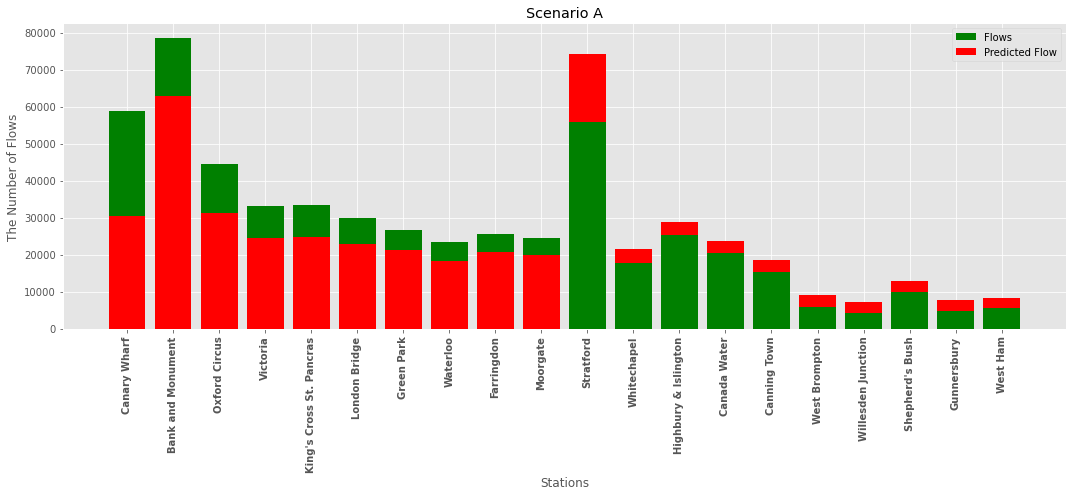

In [146]:
#plot for scenario A
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1,figsize=(15,7))
ax.set_title('Scenario A')

plt.bar(x =list(decreas['station_destination'][:10]),height = list(decreas['flows'][:10]),color = "green", label = 'Flows') 
plt.bar(x =list(decreas['station_destination'][:10]),height = list(decreas['prodsimestsa1'][:10]),color = "red", label = 'Predicted Flow')
#
plt.bar(x =list(Growth['station_destination'][-10:]),height = list(Growth['prodsimestsa1'][-10:]),color = "red")
plt.bar(x =list(Growth['station_destination'][-10:]),height = list(Growth['flows'][-10:]),color = "green") 


plt.xlabel("Stations") 
ax.set_ylabel("The Number of Flows")  
plt.xticks(list(range(20))) 
ax.set_xticklabels(list(name['station_destination']), rotation=90,weight='bold')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

### 2.2.1 Scenario B

In [150]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61456 entries, 0 to 61455
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   station_origin       61456 non-null  object 
 1   station_destination  61456 non-null  object 
 2   flows                61456 non-null  int64  
 3   population           61456 non-null  float64
 4   jobs                 61456 non-null  float64
 5   distance             61456 non-null  float64
 6   log_population       61456 non-null  float64
 7   log_jobs             61456 non-null  float64
 8   log_distance         61456 non-null  float64
 9   jobs_1               61456 non-null  float64
 10  O_i                  61456 non-null  int64  
 11  D_j                  61456 non-null  int64  
 12  prodsimest1          61456 non-null  float64
 13  alpha                61456 non-null  float64
 14  prodsimest2          61456 non-null  float64
 15  Ai1                  61456 non-null 

In [151]:
flows

,station_origin,station_destination,flows,population,jobs,distance,log_population,log_jobs,log_distance,jobs_1,O_i,D_j,prodsimest1,alpha,prodsimest2,Ai1,A_i,prodsimestsa1
0,Abbey Road,Bank and Monument,0,599.0,78549.0,8131.525097,6.395262,11.271478,9.003504,78549.0,599,78549,78.0,-2.914322,78.0,4969.549315,0.000050,148.0
1,Abbey Road,Beckton,1,599.0,442.0,8510.121774,6.395262,6.091310,9.049012,442.0,599,442,1.0,-2.914322,1.0,99.375214,0.000050,3.0
2,Abbey Road,Blackwall,3,599.0,665.0,3775.448872,6.395262,6.499787,8.236275,665.0,599,665,4.0,-2.914322,4.0,135.303172,0.000050,4.0
3,Abbey Road,Canary Wharf,1,599.0,58772.0,5086.514220,6.395262,10.981421,8.534348,29386.0,599,58772,99.0,-2.914322,59.0,2365.203174,0.000050,70.0
4,Abbey Road,Canning Town,37,599.0,15428.0,2228.923167,6.395262,9.643939,7.709274,15428.0,599,15428,56.0,-2.914322,56.0,1454.082480,0.000050,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,Woolwich Arsenal,Tower Gateway,127,7892.0,3342.0,13401.795549,8.973605,8.114325,9.503144,3342.0,7892,3342,99.0,0.518041,99.0,457.903125,0.000048,172.0
61452,Woolwich Arsenal,West Ham,608,7892.0,5487.0,8701.454361,8.973605,8.610137,9.071245,5487.0,7892,5487,295.0,0.518041,295.0,665.921567,0.000048,250.0
61453,Woolwich Arsenal,West India Quay,6,7892.0,400.0,9536.720451,8.973605,5.991465,9.162905,400.0,7892,400,36.0,0.518041,36.0,92.155736,0.000048,35.0
61454,Woolwich Arsenal,West Silvertown,81,7892.0,893.0,5355.248554,8.973605,6.794587,8.585832,893.0,7892,893,125.0,0.518041,125.0,169.034599,0.000048,64.0


#### Select 2 values for beta
##### $\beta$1 = beta*2

In [296]:
#set the new beta 1 by doubling the calibrated beta calculated before-0.0002
beta1 = beta*3

In [297]:
flows["prodsimest_b1"] = np.exp(flows["alpha"]+gamma*flows["log_jobs"] 
                                 - beta1*flows["distance"])

In [298]:
flows["prodsimest_b1"] = round(flows["prodsimest_b1"],0)
flows_mat3 = flows.pivot_table(values ="prodsimest_b1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flows_mat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,244.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,224.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,3.0,0.0,NaN,0.0,...,0.0,0.0,0.0,3.0,NaN,0.0,NaN,0.0,NaN,356.0
Aldgate,NaN,NaN,0.0,NaN,24.0,NaN,NaN,0.0,NaN,9.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,967.0
Aldgate East,NaN,NaN,0.0,26.0,NaN,NaN,0.0,0.0,NaN,9.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,1027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,194.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,106.0


In [304]:
#calculate some new alpha and beta values
Dj_gamma1 = flows["jobs"]**gamma
dist_beta1 = flows["distance"]**-beta1
#calcualte the first stage of the Ai values
flows["Ai1"] = Dj_gamma1 * dist_beta1
#now do the sum over all js bit
A_i1 = pd.DataFrame(flows.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i1["Ai1"] = 1/A_i1["Ai1"]
A_i1.rename(columns={"Ai1":"A_i1"}, inplace=True)
#and write the A_i values back into the dataframe
flows = flows.merge(A_i1, left_on="station_origin", right_index=True, how="left")

In [305]:
#to check everything works, recreate the original estimates
flows["prodsimest_beta1"] = flows["A_i1"]*flows["O_i"]*Dj_gamma1*dist_beta1
#round
flows["prodsimest_beta1"] = round(flows["prodsimest_beta1"])
#check
flows[["prodsimest1", "prodsimest_beta1", "prodsimest_b1"]]

,prodsimest1,prodsimest_beta1,prodsimest_b1
0,78.0,137.0,6.0
1,1.0,3.0,0.0
2,4.0,4.0,1.0
3,99.0,110.0,21.0
4,56.0,40.0,28.0
...,...,...,...
61451,99.0,160.0,2.0
61452,295.0,232.0,21.0
61453,36.0,32.0,2.0
61454,125.0,59.0,24.0


#### Visualize the flow change in Scenario B

In [306]:
#count the change
diff_2 = flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest1':'sum','prodsimest_beta1':'sum'})
diff_2["differences1"]= diff_2["flows"] - diff_2["prodsimest_beta1"]

diff_2["diff_abs1"]= abs(diff_2["differences1"])
diff_2.sort_values(by=["differences1"],ascending= False, inplace = True)
diff_2.head(21)


,station_destination,flows,prodsimest1,prodsimest_beta1,differences1,diff_abs1
15,Bank and Monument,78549,68371.0,61253.0,17296.0,17296.0
252,Oxford Circus,44368,39723.0,30960.0,13408.0,13408.0
356,Victoria,33251,28681.0,24253.0,8998.0,8998.0
198,King's Cross St. Pancras,33330,30521.0,24437.0,8893.0,8893.0
55,Canary Wharf,58772,47681.0,50087.0,8685.0,8685.0
214,London Bridge,29926,27123.0,22483.0,7443.0,7443.0
139,Green Park,26754,26498.0,21111.0,5643.0,5643.0
365,Waterloo,23408,22312.0,18191.0,5217.0,5217.0
120,Farringdon,25592,24153.0,20381.0,5211.0,5211.0
228,Moorgate,24574,24518.0,19685.0,4889.0,4889.0


In [396]:
diff_2.sort_values(by=["flows"],ascending= False, inplace = True)
diff_2[0:10]

,station_destination,flows,prodsimest1,prodsimest_beta1,differences1,diff_abs1
15,Bank and Monument,78549,68371.0,61253.0,17296.0,17296.0
213,Liverpool Street,61122,58847.0,59572.0,1550.0,1550.0
55,Canary Wharf,58772,47681.0,50087.0,8685.0,8685.0
327,Stratford,55954,65680.0,72828.0,-16874.0,16874.0
252,Oxford Circus,44368,39723.0,30960.0,13408.0,13408.0
198,King's Cross St. Pancras,33330,30521.0,24437.0,8893.0,8893.0
356,Victoria,33251,28681.0,24253.0,8998.0,8998.0
214,London Bridge,29926,27123.0,22483.0,7443.0,7443.0
139,Green Park,26754,26498.0,21111.0,5643.0,5643.0
120,Farringdon,25592,24153.0,20381.0,5211.0,5211.0


In [307]:
diff_2.sort_values(by=["differences1"],ascending= False, inplace = True)

In [384]:
diff_2.sort_values(by=["differences1"],ascending= False, inplace = True)
decreas_2 = diff_2[:10]
diff_2.sort_values(by=["differences1"],ascending= True, inplace = True)
Growth_2 = diff_2[:10]
name_2 = pd.concat([decreas_2,Growth_2])

In [385]:
decreas_2

,station_destination,flows,prodsimest1,prodsimest_beta1,differences1,diff_abs1
15,Bank and Monument,78549,68371.0,61253.0,17296.0,17296.0
252,Oxford Circus,44368,39723.0,30960.0,13408.0,13408.0
356,Victoria,33251,28681.0,24253.0,8998.0,8998.0
198,King's Cross St. Pancras,33330,30521.0,24437.0,8893.0,8893.0
55,Canary Wharf,58772,47681.0,50087.0,8685.0,8685.0
214,London Bridge,29926,27123.0,22483.0,7443.0,7443.0
139,Green Park,26754,26498.0,21111.0,5643.0,5643.0
365,Waterloo,23408,22312.0,18191.0,5217.0,5217.0
120,Farringdon,25592,24153.0,20381.0,5211.0,5211.0
228,Moorgate,24574,24518.0,19685.0,4889.0,4889.0


In [388]:
Growth_2

,station_destination,flows,prodsimest1,prodsimest_beta1,differences1,diff_abs1
327,Stratford,55954,65680.0,72828.0,-16874.0,16874.0
387,Whitechapel,17633,24208.0,21448.0,-3815.0,3815.0
168,Highbury & Islington,25385,29767.0,28681.0,-3296.0,3296.0
372,West Brompton,5859,8172.0,9025.0,-3166.0,3166.0
54,Canada Water,20443,25119.0,23486.0,-3043.0,3043.0
389,Willesden Junction,4165,4696.0,7126.0,-2961.0,2961.0
294,Shepherd's Bush,9890,10683.0,12716.0,-2826.0,2826.0
142,Gunnersbury,4775,4099.0,7575.0,-2800.0,2800.0
56,Canning Town,15428,16562.0,18202.0,-2774.0,2774.0
278,Richmond,5397,2605.0,8045.0,-2648.0,2648.0


In [386]:
name_2

,station_destination,flows,prodsimest1,prodsimest_beta1,differences1,diff_abs1
15,Bank and Monument,78549,68371.0,61253.0,17296.0,17296.0
252,Oxford Circus,44368,39723.0,30960.0,13408.0,13408.0
356,Victoria,33251,28681.0,24253.0,8998.0,8998.0
198,King's Cross St. Pancras,33330,30521.0,24437.0,8893.0,8893.0
55,Canary Wharf,58772,47681.0,50087.0,8685.0,8685.0
214,London Bridge,29926,27123.0,22483.0,7443.0,7443.0
139,Green Park,26754,26498.0,21111.0,5643.0,5643.0
365,Waterloo,23408,22312.0,18191.0,5217.0,5217.0
120,Farringdon,25592,24153.0,20381.0,5211.0,5211.0
228,Moorgate,24574,24518.0,19685.0,4889.0,4889.0


In [397]:
name_3

,station_destination,flows,prodsimest1,prodsimest_beta2,differences2,diff_abs2
55,Canary Wharf,58772,47681.0,49095.0,9677.0,9677.0
15,Bank and Monument,78549,68371.0,70850.0,7699.0,7699.0
252,Oxford Circus,44368,39723.0,37082.0,7286.0,7286.0
356,Victoria,33251,28681.0,26853.0,6398.0,6398.0
148,Hammersmith,18250,12982.0,13123.0,5127.0,5127.0
198,King's Cross St. Pancras,33330,30521.0,28619.0,4711.0,4711.0
253,Paddington,20193,17077.0,16129.0,4064.0,4064.0
398,Woolwich Arsenal,4428,1089.0,954.0,3474.0,3474.0
390,Wimbledon,6295,1983.0,3152.0,3143.0,3143.0
74,Clapham Junction,4969,1562.0,1852.0,3117.0,3117.0


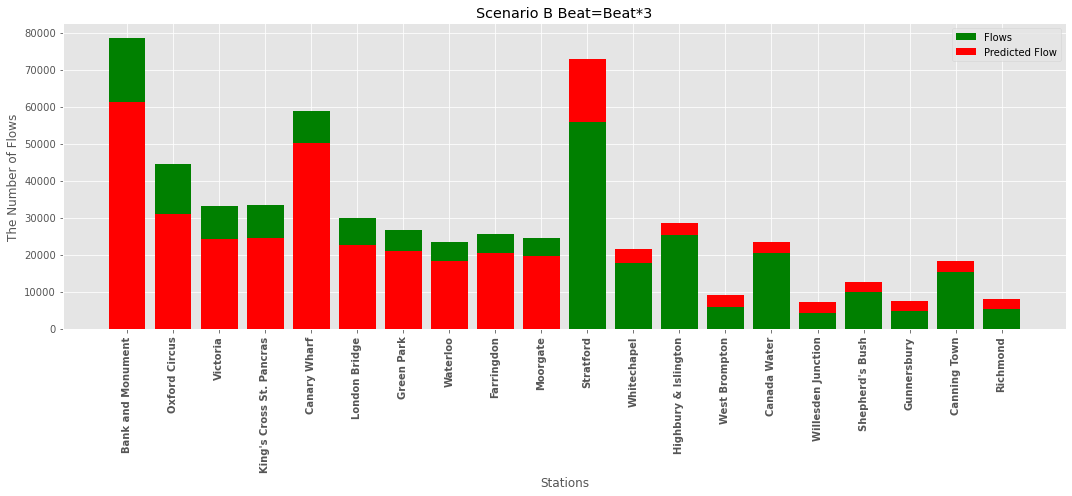

In [387]:
#plot for scenario A
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1,figsize=(15,7))
ax.set_title('Scenario B Beat=Beat*3')

plt.bar(x =list(decreas_2['station_destination'][:10]),height = list(decreas_2['flows'][:10]),color = "green", label = 'Flows') 
plt.bar(x =list(decreas_2['station_destination'][:10]),height = list(decreas_2['prodsimest_beta1'][:10]),color = "red", label = 'Predicted Flow')
#
plt.bar(x =list(Growth_2['station_destination'][-10:]),height = list(Growth_2['prodsimest_beta1'][-10:]),color = "red")
plt.bar(x =list(Growth_2['station_destination'][-10:]),height = list(Growth_2['flows'][-10:]),color = "green") 


plt.xlabel("Stations") 
ax.set_ylabel("The Number of Flows")  
plt.xticks(list(range(20))) 
ax.set_xticklabels(list(name_2['station_destination']), rotation=90,weight='bold')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

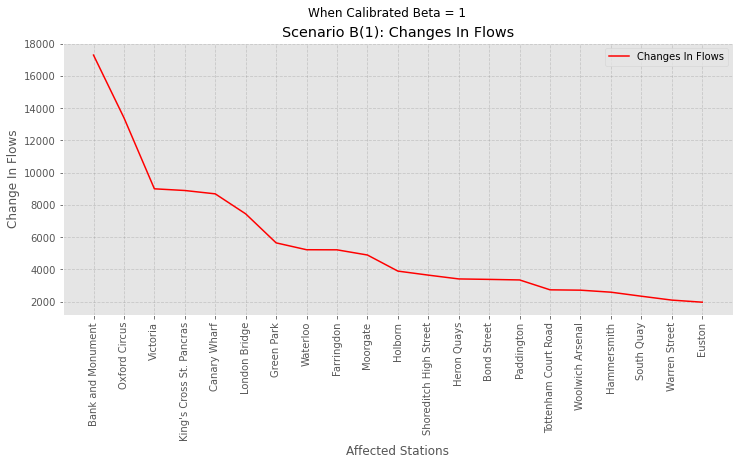

In [308]:
#plot for scenario B when beta is doubling from the calibrated parameter beta
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Scenario B(1): Changes In Flows')
fig.suptitle("When Calibrated Beta = 1") 
ax.plot(list(diff_2['diff_abs1'])[:21], color = "red", label = 'Changes In Flows') 
ax.grid(color='grey', linestyle='--',alpha=0.3) 
ax.set_xlabel("Affected Stations") 
ax.set_ylabel("Change In Flows")  
ax.set_xticks(list(range(21))) 
ax.set_xticklabels(list(diff_2['station_destination'])[:21], rotation=90)
ax.legend(loc=1)
plt.show()

##### $\beta$2 = beta*10

In [340]:
#set the new beta = 2
beta2 = 1

In [341]:
flows["prodsimest_b2"] = np.exp(flows["alpha"]+gamma*np.log(flows["jobs"]) - beta2*flows["distance"])
flows["prodsimest_b2"] = round(flows["prodsimest_b2"],0)

In [342]:
flows_mat4 = flows.pivot_table(values ="prodsimest_b2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
flows_mat4

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0
Acton Town,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0
Aldgate East,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
Woodside Park,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [345]:
#calculate some new alpha and beta values
Dj_gamma2 = flows["jobs"]**gamma
dist_beta2 = flows["distance"]**-beta2
#calcualte the first stage of the Ai values
flows["Ai1"] = Dj_gamma2 * dist_beta2
#now do the sum over all js bit
A_i2 = pd.DataFrame(flows.groupby(["station_origin"])["Ai1"].agg(np.sum))
#now divide into 1
A_i2["Ai1"] = 1/A_i2["Ai1"]
A_i2.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
flows = flows.merge(A_i2, left_on="station_origin", right_index=True, how="left")

In [346]:
#to check everything works, recreate the original estimates
flows["prodsimest_beta2"] = flows["A_i2"]*flows["O_i"]*Dj_gamma2*dist_beta2
#round
flows["prodsimest_beta2"] = round(flows["prodsimest_beta2"])
#check
flows[["prodsimest1", "prodsimest_beta2"]]

,prodsimest1,prodsimest_beta2
0,78.0,45.0
1,1.0,1.0
2,4.0,3.0
3,99.0,58.0
4,56.0,48.0
...,...,...
61451,99.0,118.0
61452,295.0,265.0
61453,36.0,33.0
61454,125.0,109.0


#### Visualize the flow change in Scenario B

In [347]:
#count the change
diff_3 = flows.groupby('station_destination',as_index=False).agg({'flows':'sum','prodsimest1':'sum','prodsimest_beta2':'sum'})
diff_3["differences2"]= diff_3["flows"] - diff_3["prodsimest_beta2"]

diff_3["diff_abs2"]= abs(diff_3["differences2"])
diff_3.sort_values(by=["diff_abs2"],ascending= False, inplace = True)
diff_3.head(21)

,station_destination,flows,prodsimest1,prodsimest_beta2,differences2,diff_abs2
55,Canary Wharf,58772,47681.0,49095.0,9677.0,9677.0
15,Bank and Monument,78549,68371.0,70850.0,7699.0,7699.0
327,Stratford,55954,65680.0,63319.0,-7365.0,7365.0
252,Oxford Circus,44368,39723.0,37082.0,7286.0,7286.0
356,Victoria,33251,28681.0,26853.0,6398.0,6398.0
148,Hammersmith,18250,12982.0,13123.0,5127.0,5127.0
54,Canada Water,20443,25119.0,25342.0,-4899.0,4899.0
387,Whitechapel,17633,24208.0,22531.0,-4898.0,4898.0
198,King's Cross St. Pancras,33330,30521.0,28619.0,4711.0,4711.0
253,Paddington,20193,17077.0,16129.0,4064.0,4064.0


In [389]:
diff_3.sort_values(by=["differences2"],ascending= False, inplace = True)
decreas_3 = diff_3[:10]
diff_3.sort_values(by=["differences2"],ascending= True, inplace = True)
Growth_3 = diff_3[:10]
name_3 = pd.concat([decreas_3,Growth_3])

In [390]:
name_3

,station_destination,flows,prodsimest1,prodsimest_beta2,differences2,diff_abs2
55,Canary Wharf,58772,47681.0,49095.0,9677.0,9677.0
15,Bank and Monument,78549,68371.0,70850.0,7699.0,7699.0
252,Oxford Circus,44368,39723.0,37082.0,7286.0,7286.0
356,Victoria,33251,28681.0,26853.0,6398.0,6398.0
148,Hammersmith,18250,12982.0,13123.0,5127.0,5127.0
198,King's Cross St. Pancras,33330,30521.0,28619.0,4711.0,4711.0
253,Paddington,20193,17077.0,16129.0,4064.0,4064.0
398,Woolwich Arsenal,4428,1089.0,954.0,3474.0,3474.0
390,Wimbledon,6295,1983.0,3152.0,3143.0,3143.0
74,Clapham Junction,4969,1562.0,1852.0,3117.0,3117.0


In [392]:
Growth_3

,station_destination,flows,prodsimest1,prodsimest_beta2,differences2,diff_abs2
327,Stratford,55954,65680.0,63319.0,-7365.0,7365.0
54,Canada Water,20443,25119.0,25342.0,-4899.0,4899.0
387,Whitechapel,17633,24208.0,22531.0,-4898.0,4898.0
113,Embankment,10220,13101.0,14162.0,-3942.0,3942.0
314,Southwark,10326,12546.0,14093.0,-3767.0,3767.0
384,Westminster,15466,17308.0,18544.0,-3078.0,3078.0
57,Cannon Street,4698,6653.0,7597.0,-2899.0,2899.0
65,Charing Cross,7016,9763.0,9825.0,-2809.0,2809.0
168,Highbury & Islington,25385,29767.0,28131.0,-2746.0,2746.0
375,West Ham,5487,7821.0,8131.0,-2644.0,2644.0


In [380]:
decreas_3

,station_destination,flows,prodsimest1,prodsimest_beta2,differences2,diff_abs2
55,Canary Wharf,58772,47681.0,49095.0,9677.0,9677.0
15,Bank and Monument,78549,68371.0,70850.0,7699.0,7699.0
252,Oxford Circus,44368,39723.0,37082.0,7286.0,7286.0
356,Victoria,33251,28681.0,26853.0,6398.0,6398.0
148,Hammersmith,18250,12982.0,13123.0,5127.0,5127.0
198,King's Cross St. Pancras,33330,30521.0,28619.0,4711.0,4711.0
253,Paddington,20193,17077.0,16129.0,4064.0,4064.0
398,Woolwich Arsenal,4428,1089.0,954.0,3474.0,3474.0
390,Wimbledon,6295,1983.0,3152.0,3143.0,3143.0
74,Clapham Junction,4969,1562.0,1852.0,3117.0,3117.0


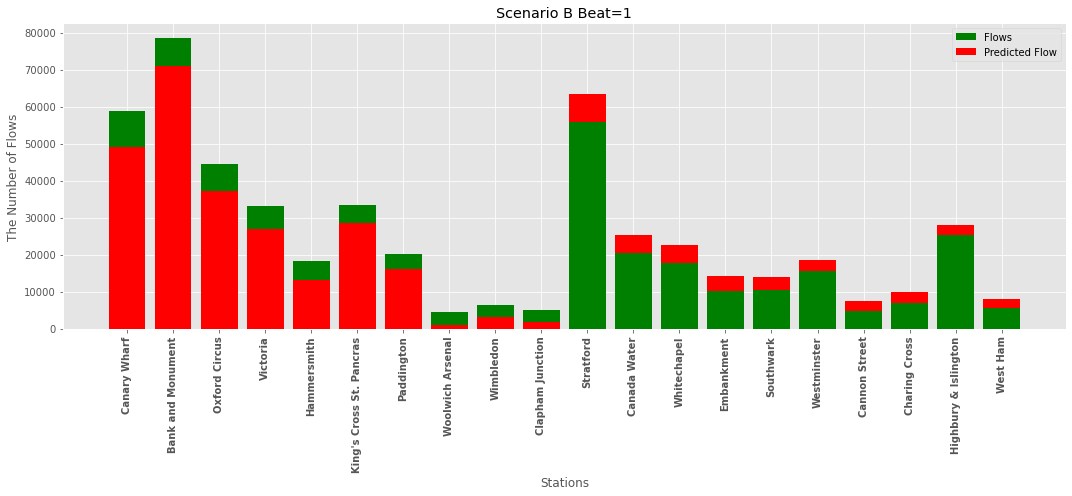

In [391]:
#plot for scenario A
plt.style.use('ggplot')
fig, ax = plt.subplots(1,1,figsize=(15,7))
ax.set_title('Scenario B Beat=1')

ax.bar(x =list(decreas_3['station_destination'][:10]),height = list(decreas_3['flows'][:10]),color = "green", label = 'Flows') 
ax.bar(x =list(decreas_3['station_destination'][:10]),height = list(decreas_3['prodsimest_beta2'][:10]),color = "red", label = 'Predicted Flow')
#
plt.bar(x =list(Growth_3['station_destination'][-10:]),height = list(Growth_3['prodsimest_beta2'][-10:]),color = "red")
plt.bar(x =list(Growth_3['station_destination'][-10:]),height = list(Growth_3['flows'][-10:]),color = "green") 


plt.xlabel("Stations") 
ax.set_ylabel("The Number of Flows")  
plt.xticks(list(range(20))) 
ax.set_xticklabels(list(name_3['station_destination']), rotation=90,weight='bold')
ax.legend(loc=1)
plt.tight_layout()
plt.show()

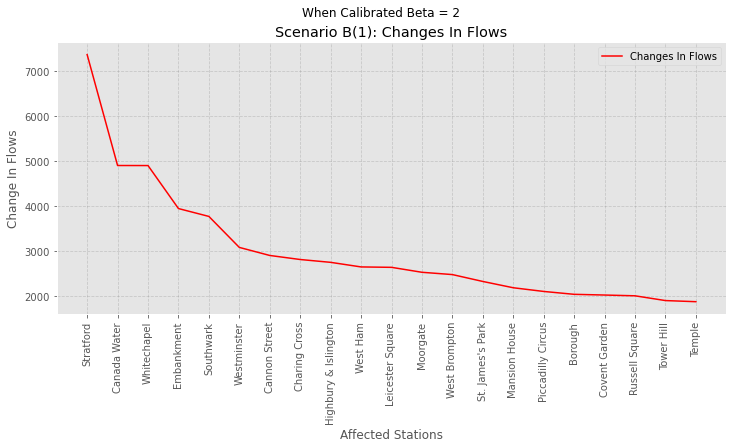

In [353]:
#plot for scenario B when beta is doubling from the calibrated parameter beta
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.set_title('Scenario B(1): Changes In Flows')
fig.suptitle("When Calibrated Beta = 2") 
ax.plot(list(diff_3['diff_abs2'])[:21], color = "red", label = 'Changes In Flows') 
ax.grid(color='grey', linestyle='--',alpha=0.3) 
ax.set_xlabel("Affected Stations") 
ax.set_ylabel("Change In Flows")  
ax.set_xticks(list(range(21))) 
ax.set_xticklabels(list(diff_3['station_destination'])[:21], rotation=90)
ax.legend(loc=1)
plt.show()

In [354]:
diff_3.head(21)

,station_destination,flows,prodsimest1,prodsimest_beta2,differences2,diff_abs2
327,Stratford,55954,65680.0,63319.0,-7365.0,7365.0
54,Canada Water,20443,25119.0,25342.0,-4899.0,4899.0
387,Whitechapel,17633,24208.0,22531.0,-4898.0,4898.0
113,Embankment,10220,13101.0,14162.0,-3942.0,3942.0
314,Southwark,10326,12546.0,14093.0,-3767.0,3767.0
384,Westminster,15466,17308.0,18544.0,-3078.0,3078.0
57,Cannon Street,4698,6653.0,7597.0,-2899.0,2899.0
65,Charing Cross,7016,9763.0,9825.0,-2809.0,2809.0
168,Highbury & Islington,25385,29767.0,28131.0,-2746.0,2746.0
375,West Ham,5487,7821.0,8131.0,-2644.0,2644.0


In [355]:
diff_2.head(21)

,station_destination,flows,prodsimest1,prodsimest_beta1,differences1,diff_abs1
327,Stratford,55954,65680.0,72828.0,-16874.0,16874.0
387,Whitechapel,17633,24208.0,21448.0,-3815.0,3815.0
168,Highbury & Islington,25385,29767.0,28681.0,-3296.0,3296.0
372,West Brompton,5859,8172.0,9025.0,-3166.0,3166.0
54,Canada Water,20443,25119.0,23486.0,-3043.0,3043.0
389,Willesden Junction,4165,4696.0,7126.0,-2961.0,2961.0
294,Shepherd's Bush,9890,10683.0,12716.0,-2826.0,2826.0
142,Gunnersbury,4775,4099.0,7575.0,-2800.0,2800.0
56,Canning Town,15428,16562.0,18202.0,-2774.0,2774.0
278,Richmond,5397,2605.0,8045.0,-2648.0,2648.0


In [356]:
diff_1

,station_destination,flows,prodsimest2,prodsimestsa1,differences,diff_abs,change
327,Stratford,55954,65680.0,74119.0,-18165.0,18165.0,-0.011778
387,Whitechapel,17633,24208.0,21640.0,-4007.0,4007.0,-0.002598
168,Highbury & Islington,25385,29767.0,28929.0,-3544.0,3544.0,-0.002298
54,Canada Water,20443,25119.0,23714.0,-3271.0,3271.0,-0.002121
56,Canning Town,15428,16562.0,18687.0,-3259.0,3259.0,-0.002113
...,...,...,...,...,...,...,...
198,King's Cross St. Pancras,33330,30521.0,24717.0,8613.0,8613.0,0.005585
356,Victoria,33251,28681.0,24541.0,8710.0,8710.0,0.005647
252,Oxford Circus,44368,39723.0,31325.0,13043.0,13043.0,0.008457
15,Bank and Monument,78549,68371.0,62870.0,15679.0,15679.0,0.010166


In [423]:
compare = diff_1[['station_destination','flows','prodsimestsa1']]

In [424]:
compare = pd.merge(compare,diff_2[['prodsimest_beta1','station_destination']],on='station_destination')

In [425]:
compare = pd.merge(compare,diff_3[['prodsimest_beta2','station_destination']],on='station_destination')

In [426]:
compare.rename(columns={'flows':'Initial flows'},inplace=True)
compare.rename(columns={'prodsimestsa1':'Scenario A'},inplace=True)
compare.rename(columns={'prodsimest_beta1':'Scenario B (Triple Beta)'},inplace=True)
compare.rename(columns={'prodsimest_beta2':'Scenario B (Beta=1)'},inplace=True)

In [427]:
NameDF = compare['station_destination']

In [428]:
NameDF.reset_index()

,index,station_destination
0,0,Stratford
1,1,Whitechapel
2,2,Highbury & Islington
3,3,Canada Water
4,4,Canning Town
...,...,...
394,394,King's Cross St. Pancras
395,395,Victoria
396,396,Oxford Circus
397,397,Bank and Monument


In [429]:
compare

,station_destination,Initial flows,Scenario A,Scenario B (Triple Beta),Scenario B (Beta=1)
0,Stratford,55954,74119.0,72828.0,63319.0
1,Whitechapel,17633,21640.0,21448.0,22531.0
2,Highbury & Islington,25385,28929.0,28681.0,28131.0
3,Canada Water,20443,23714.0,23486.0,25342.0
4,Canning Town,15428,18687.0,18202.0,16619.0
...,...,...,...,...,...
394,King's Cross St. Pancras,33330,24717.0,24437.0,28619.0
395,Victoria,33251,24541.0,24253.0,26853.0
396,Oxford Circus,44368,31325.0,30960.0,37082.0
397,Bank and Monument,78549,62870.0,61253.0,70850.0


In [434]:
compare.sort_values(by=["Initial flows"],ascending= False, inplace = True)
compare[0:10].to_csv('1.csv')

In [431]:
compare['ChangeA%']=((compare['Scenario A']-compare['Initial flows'])/compare['Initial flows'])*100
compare['ChangeB2%']=((compare['Scenario B (Triple Beta)']-compare['Initial flows'])/compare['Initial flows'])*100
compare['ChangeB3%']=((compare['Scenario B (Beta=1)']-compare['Initial flows'])/compare['Initial flows'])*100

In [432]:
print(max(compare['ChangeA%']))
print(max(compare['ChangeB2%']))
print(max(compare['ChangeB3%']))

131.86813186813185
127.52525252525253
131.42857142857142


In [433]:
print(min(compare['ChangeB3%']))

-78.45528455284553


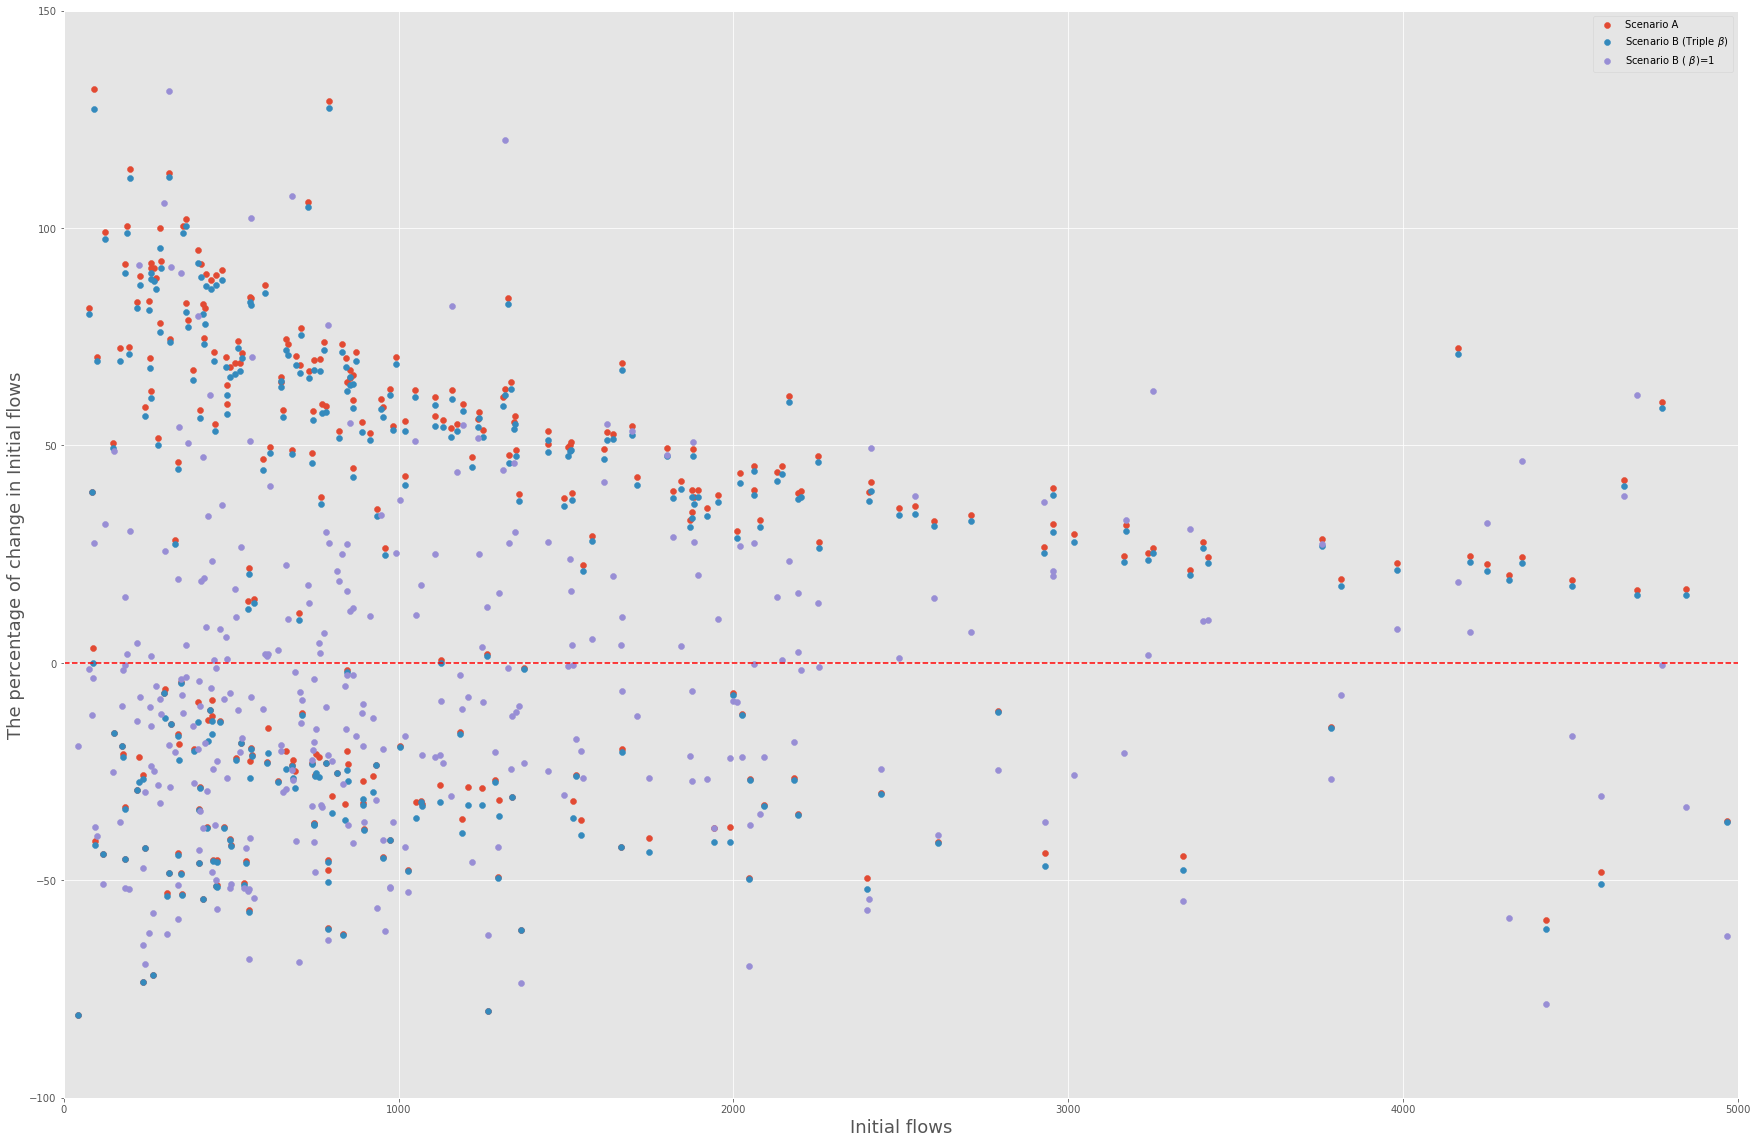

In [442]:
fig, ax = plt.subplots(figsize=(30,20))

alpha=0.7
plt.xlim(0,5000)
plt.ylim(-100,150)
plt.scatter(compare['Initial flows'],compare['ChangeA%'],alpha=1,label='Scenario A')
plt.scatter(compare['Initial flows'],compare['ChangeB2%'],alpha=1,label=r'Scenario B (Triple $\beta$)')
plt.scatter(compare['Initial flows'],compare['ChangeB3%'],alpha=1,label=r'Scenario B ( $\beta$)=1')

plt.axhline(color="red", linestyle="--")
ax.legend()
ax.grid(True)
ax.set_xlabel('Initial flows', fontsize=18)
ax.set_ylabel('The percentage change in Initial flows', fontsize=18)
plt.savefig('Figure6_compare.png',dpi=600)
plt.show()